In [1]:
import os
import math
import random
from typing import Optional, Tuple, Dict, Any

import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
from google.colab import drive

In [2]:
csv_path = "/kaggle/input/brisc-dataset/train_index1.csv"  # user-provided path
image_col = "image_path"
mask_col = "mask_path"
class_col = "cls_label"

In [3]:
# Set according to dataset
seg_num_classes = 2          # e.g., background=0, tumor=1
clf_num_classes = 4          # from CSV, appears to have labels like 1,3,... adjust to actual class count
input_size = (256, 256)      # training crop/resize
batch_size = 8
num_workers = 2
seed = 42
device = "cuda" if torch.cuda.is_available() else "cpu"

# Loss weights for joint training
lambda_seg = 1.0
lambda_clf = 1.0

In [4]:
def set_seed(s=42):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)

set_seed(seed)

def str_or_nan(s):
    if pd.isna(s) or (isinstance(s, float) and math.isnan(s)):
        return None
    s = str(s).strip()
    return s if s else None


In [5]:
class SegClfDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transforms: Optional[A.BasicTransform]=None, seg_num_classes: int=2, input_size: Tuple[int, int]=(512, 512)):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms
        self.seg_num_classes = seg_num_classes
        self.input_size = input_size


        # Pre-parse items
        self.items = []
        for _, row in self.df.iterrows():
            img_path = str(row[image_col]).strip()
            mask_path = str_or_nan(row[mask_col])
            cls_label = int(row[class_col])

            # Some rows list a mask that may not exist on disk; treat as missing if file not found
            has_mask = mask_path is not None and os.path.exists(mask_path)
            self.items.append({
                "img": img_path,
                "mask": mask_path if has_mask else None,
                "has_mask": has_mask,
                "cls": cls_label
            })

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        item = self.items[idx]
        img = np.array(Image.open(item["img"]).convert("RGB"))

        mask = None
        if item["has_mask"]:
            # Expecting integer labels in mask
            mask_pil = Image.open(item["mask"])
            mask = np.array(mask_pil)
            # If mask is RGB, convert to single channel by taking one channel or remapping as needed
            if mask.ndim == 3:
                # Heuristic: if mask is RGB with color coding, take one channel (assuming binary), adapt if needed
                mask = mask[..., 0]
            # Ensure mask contains values 0..(seg_num_classes-1)
            # If masks are {0,255}, map 255->1 for binary
            if self.seg_num_classes == 2 and mask.max() > 1:
                mask = (mask > 0).astype(np.uint8)

        if self.transforms is not None:
            if mask is not None:
                aug = self.transforms(image=img, mask=mask)
                img = aug["image"]
                mask = aug["mask"]
            else:
                aug = self.transforms(image=img)
                img = aug["image"]
                mask = None

        sample = {
            "image": img,     # Tensor CxHxW
            "label": torch.tensor(item["cls"], dtype=torch.long)
        }
        if mask is not None:
            # For CrossEntropyLoss, mask should be Long with shape HxW
            if isinstance(mask, torch.Tensor):
                # Already tensor via ToTensorV2
                mask_t = mask.long().squeeze()
            else:
                mask_t = torch.from_numpy(mask).long()
            sample["mask"] = mask_t
            sample["has_mask"] = torch.tensor(1, dtype=torch.uint8)
        else:
            # Create a zero mask of the expected size
            sample["mask"] = torch.zeros(self.input_size, dtype=torch.long)
            sample["has_mask"] = torch.tensor(0, dtype=torch.uint8)


        return sample

In [6]:
train_tf = A.Compose([
    A.LongestMaxSize(max(input_size)),
    A.PadIfNeeded(min_height=512, min_width=512, border_mode=0, value=0, mask_value=0),
    A.RandomCrop(height=512, width=512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    # Elastic deformation is a key augmentation in U-Net paper
    A.ElasticTransform(p=0.3, alpha=50, sigma=6, alpha_affine=20),
    A.ColorJitter(p=0.3, brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

val_tf = A.Compose([
    A.LongestMaxSize(max(input_size)),
    A.PadIfNeeded(min_height=512, min_width=512, border_mode=0, value=0, mask_value=0),
    A.CenterCrop(height=512, width=512),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

/tmp/ipykernel_19/1298754721.py:3: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=512, min_width=512, border_mode=0, value=0, mask_value=0),
/tmp/ipykernel_19/1298754721.py:9: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.3, alpha=50, sigma=6, alpha_affine=20),
/tmp/ipykernel_19/1298754721.py:17: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=512, min_width=512, border_mode=0, value=0, mask_value=0),


In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )
    def forward(self, x):
        return self.net(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_ch, out_ch)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Pad x1 to the size of x2 if needed
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3] # Access dimensions directly
        x1 = F.pad(x1, [diffX // 2, diffX - diffX//2, diffY // 2, diffY - diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNetWithClassifier(nn.Module):
    def __init__(self, n_channels=3, n_classes=2, clf_classes=4, bilinear=True, base_ch=64):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Encoder
        self.inc = DoubleConv(n_channels, base_ch)         # 64
        self.down1 = Down(base_ch, base_ch*2)              # 128
        self.down2 = Down(base_ch*2, base_ch*4)            # 256
        self.down3 = Down(base_ch*4, base_ch*8)            # 512
        factor = 2 if bilinear else 1
        self.down4 = Down(base_ch*8, base_ch*16 // factor) # 1024->512 if bilinear

        # Decoder (Segmentation head)
        self.up1 = Up(base_ch*16, base_ch*8 // factor, bilinear=bilinear)
        self.up2 = Up(base_ch*8, base_ch*4 // factor, bilinear=bilinear)
        self.up3 = Up(base_ch*4, base_ch*2 // factor, bilinear=bilinear)
        self.up4 = Up(base_ch*2, base_ch, bilinear=bilinear)
        self.seg_out = nn.Conv2d(base_ch, n_classes, kernel_size=1)

        # Classifier head on bottleneck
        bottleneck_ch = base_ch*16 // factor
        self.clf_pool = nn.AdaptiveAvgPool2d(1)
        self.clf_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(bottleneck_ch, bottleneck_ch//2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(bottleneck_ch//2, clf_classes)
        )

    def encode(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        return x1, x2, x3, x4, x5

    def decode(self, x1, x2, x3, x4, x5):
        y = self.up1(x5, x4)
        y = self.up2(y, x3)
        y = self.up3(y, x2)
        y = self.up4(y, x1)
        logits = self.seg_out(y)
        return logits

    def classify(self, x5):
        pooled = self.clf_pool(x5)
        logits = self.clf_head(pooled)
        return logits

    def forward(self, x, return_both=True):
        x1, x2, x3, x4, x5 = self.encode(x)
        seg_logits = self.decode(x1, x2, x3, x4, x5) if return_both else None
        clf_logits = self.classify(x5)
        return seg_logits, clf_logits

In [8]:
# -----------------------------
# Losses and metrics
# -----------------------------
def dice_coefficient(pred_logits, target, num_classes, eps=1e-6):
    # pred: NxCxHxW logits -> softmax to probs
    probs = F.softmax(pred_logits, dim=1)
    # One-hot target
    n, c, h, w = probs.shape
    target_oh = F.one_hot(target, num_classes=c).permute(0,3,1,2).float()
    dims = (0,2,3)
    intersection = torch.sum(probs * target_oh, dims)
    cardinality = torch.sum(probs + target_oh, dims)
    dice = (2. * intersection + eps) / (cardinality + eps)
    # Return mean over classes
    return dice.mean()

In [9]:
# -----------------------------
# Training helpers
# -----------------------------
def train_one_epoch(model, loader, optimizer, seg_criterion, clf_criterion, mode="joint"):
    model.train()
    total_loss = 0.0
    total_seg_loss = 0.0
    total_clf_loss = 0.0
    total = 0

    for batch in loader:
        imgs = batch["image"].to(device)
        labels = batch["label"].to(device)
        has_mask = batch["has_mask"].to(device).float()
        masks = batch["mask"].to(device)

        optimizer.zero_grad()

        if mode == "seg_only":
            seg_logits, _ = model(imgs, return_both=True)
            # Compute loss for all samples and mask out those without masks
            seg_loss = seg_criterion(seg_logits, masks)
            # Ensure has_mask is broadcastable for element-wise multiplication
            seg_loss = (seg_loss * has_mask.unsqueeze(1).unsqueeze(2).unsqueeze(3)).mean()
            loss = seg_loss
            clf_loss = torch.tensor(0.0, device=device)

        elif mode == "clf_only":
            _, clf_logits = model(imgs, return_both=False)  # skip decoder computation
            clf_loss = clf_criterion(clf_logits, labels)
            loss = clf_loss
            seg_loss = torch.tensor(0.0, device=device)

        else:  # joint
            seg_logits, clf_logits = model(imgs, return_both=True)
            # Segmentation loss on available masks
            seg_loss = seg_criterion(seg_logits, masks)
            # Ensure has_mask is broadcastable for element-wise multiplication
            seg_loss = (seg_loss * has_mask.unsqueeze(1).unsqueeze(2).unsqueeze(3)).mean()

            clf_loss = clf_criterion(clf_logits, labels)
            loss = lambda_seg * seg_loss + lambda_clf * clf_loss

        loss.backward()
        optimizer.step()

        bs = imgs.size(0)
        total += bs
        total_loss += loss.item() * bs
        total_seg_loss += seg_loss.item() * bs
        total_clf_loss += clf_loss.item() * bs

    return {
        "loss": total_loss / total,
        "seg_loss": total_seg_loss / total,
        "clf_loss": total_clf_loss / total
    }

@torch.no_grad()
def evaluate(model, loader, seg_criterion, clf_criterion, mode="joint"):
    model.eval()
    total_loss = 0.0
    total_seg_loss = 0.0
    total_clf_loss = 0.0
    total = 0
    # Metrics
    total_dice = 0.0
    dice_count = 0
    correct = 0
    total_samples = 0

    # Initialize seg_loss_masked
    seg_loss_masked = torch.tensor(0.0, device=device)

    for batch in loader:
        imgs = batch["image"].to(device)
        labels = batch["label"].to(device)
        has_mask = batch["has_mask"].to(device).float()
        masks = batch["mask"].to(device)

        if mode == "seg_only":
            seg_logits, _ = model(imgs, return_both=True)
            seg_loss = seg_criterion(seg_logits, masks)
            # Ensure has_mask is broadcastable for element-wise multiplication
            seg_loss_masked = (seg_loss * has_mask.unsqueeze(1).unsqueeze(2).unsqueeze(3)).mean()

            if has_mask.sum() > 0:
                # Dice on masked samples (only for samples with masks)
                # Need to filter seg_logits and masks based on has_mask
                seg_logits_masked = seg_logits[has_mask.bool()]
                masks_masked = masks[has_mask.bool()]
                if seg_logits_masked.numel() > 0 and masks_masked.numel() > 0:
                    total_dice += dice_coefficient(seg_logits_masked, masks_masked, num_classes=model.n_classes).item()
                    dice_count += 1

            loss = seg_loss_masked
            clf_loss = torch.tensor(0.0, device=device)

        elif mode == "clf_only":
            _, clf_logits = model(imgs, return_both=False)
            clf_loss = clf_criterion(clf_logits, labels)
            loss = clf_loss
            seg_loss = torch.tensor(0.0, device=device)

            # Accuracy
            preds = clf_logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

        else:  # joint
            seg_logits, clf_logits = model(imgs, return_both=True)
            seg_loss = seg_criterion(seg_logits, masks)
            # Ensure has_mask is broadcastable for element-wise multiplication
            seg_loss_masked = (seg_loss * has_mask.unsqueeze(1).unsqueeze(2).unsqueeze(3)).mean()

            if has_mask.sum() > 0:
                 # Dice on masked samples (only for samples with masks)
                seg_logits_masked = seg_logits[has_mask.bool()]
                masks_masked = masks[has_mask.bool()]
                if seg_logits_masked.numel() > 0 and masks_masked.numel() > 0:
                    total_dice += dice_coefficient(seg_logits_masked, masks_masked, num_classes=model.n_classes).item()
                    dice_count += 1

            clf_loss = clf_criterion(clf_logits, labels)
            loss = lambda_seg * seg_loss_masked + lambda_clf * clf_loss

            preds = clf_logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

        bs = imgs.size(0)
        total += bs
        total_loss += loss.item() * bs
        total_seg_loss += seg_loss_masked.item() * bs # Use masked loss for logging
        total_clf_loss += clf_loss.item() * bs

    metrics = {
        "loss": total_loss / total,
        "seg_loss": total_seg_loss / total,
        "clf_loss": total_clf_loss / total,
    }
    if dice_count > 0:
        metrics["dice"] = total_dice / dice_count
    if total_samples > 0:
        metrics["acc"] = correct / total_samples
    return metrics

In [10]:
# -----------------------------
# Data split and loaders
# -----------------------------
df = pd.read_csv(csv_path)
# Basic sanity: ensure files exist; drop missing images
df = df[df[image_col].apply(lambda p: isinstance(p, str) and os.path.exists(p))].reset_index(drop=True)

# Stratify by class for balanced splits
train_df, val_df = train_test_split(df, test_size=0.2, random_state=seed, stratify=df[class_col])

train_ds = SegClfDataset(train_df, transforms=train_tf, seg_num_classes=seg_num_classes)
val_ds   = SegClfDataset(val_df,   transforms=val_tf,   seg_num_classes=seg_num_classes)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

In [11]:
# -----------------------------
# Instantiate model and criteria
# -----------------------------
model = UNetWithClassifier(n_channels=3, n_classes=seg_num_classes, clf_classes=clf_num_classes, bilinear=True, base_ch=64).to(device)

# Losses
seg_criterion = nn.CrossEntropyLoss()  # can swap to DiceCE combo if desired
clf_criterion = nn.CrossEntropyLoss()

In [12]:
# -----------------------------
# Optimizers and schedulers
# -----------------------------
def make_optimizer(lr=1e-3, wd=1e-4):
    return torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

def make_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [13]:
# -----------------------------
# Training loops
# -----------------------------

# =============================
# Logging, plotting, checkpoints
# =============================
import os, json, torch
from datetime import datetime
import matplotlib.pyplot as plt

out_dir = "/kaggle/working/"
ckpt_dir = os.path.join(out_dir, "checkpoints")
fig_dir = os.path.join(out_dir, "figs")
os.makedirs(ckpt_dir, exist_ok=True)
os.makedirs(fig_dir, exist_ok=True)

def run_training_with_logging(mode="seg_only", epochs=10, lr=1e-3, tag=None):
    assert mode in ["seg_only", "clf_only", "joint"]
    optimizer = make_optimizer(lr=lr)
    scheduler = make_scheduler(optimizer)

    best_val = float('inf')
    best_state = None

    history = {
        "epoch": [],
        "train_loss": [],
        "train_seg_loss": [],
        "train_clf_loss": [],
        "val_loss": [],
        "val_seg_loss": [],
        "val_clf_loss": [],
        "val_dice": [],
        "val_acc": []
    }

    time_tag = datetime.now().strftime("%Y%m%d-%H%M%S")
    run_tag = tag or f"{mode}_{time_tag}"

    for epoch in range(1, epochs+1):
        tr_metrics = train_one_epoch(model, train_loader, optimizer, seg_criterion, clf_criterion, mode=mode)
        val_metrics = evaluate(model, val_loader, seg_criterion, clf_criterion, mode=mode)

        scheduler.step(val_metrics["loss"])

        # Save per-epoch checkpoint (full state)
        torch.save({
            "epoch": epoch,
            "mode": mode,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "val_loss": val_metrics["loss"],
        }, os.path.join(ckpt_dir, f"{run_tag}_epoch{epoch:02d}.pth"))

        # Track best weights
        if val_metrics["loss"] < best_val:
            best_val = val_metrics["loss"]
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            torch.save(best_state, os.path.join(ckpt_dir, f"{run_tag}_best_weights.pth"))

        # Log history
        history["epoch"].append(epoch)
        history["train_loss"].append(tr_metrics["loss"])
        history["train_seg_loss"].append(tr_metrics.get("seg_loss", 0.0))
        history["train_clf_loss"].append(tr_metrics.get("clf_loss", 0.0))
        history["val_loss"].append(val_metrics["loss"])
        history["val_seg_loss"].append(val_metrics.get("seg_loss", 0.0))
        history["val_clf_loss"].append(val_metrics.get("clf_loss", 0.0))
        history["val_dice"].append(val_metrics.get("dice", None))
        history["val_acc"].append(val_metrics.get("acc", None))

        print(f"[{mode}] Epoch {epoch:02d}: "
              f"train_loss={tr_metrics['loss']:.4f} seg={tr_metrics['seg_loss']:.4f} clf={tr_metrics['clf_loss']:.4f} | "
              f"val_loss={val_metrics['loss']:.4f} seg={val_metrics['seg_loss']:.4f} clf={val_metrics['clf_loss']:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)

    # Save history JSON
    with open(os.path.join(out_dir, f"history_{run_tag}.json"), "w") as f:
        json.dump(history, f, indent=2)

    # Plot helpers
    def _plot_series(xs, series, title, fname, ylabel="Loss"):
        plt.figure(figsize=(7,5))
        for lbl, ys in series.items():
            if ys is None: 
                continue
            plt.plot(xs, ys, label=lbl)
        plt.xlabel("Epoch")
        plt.ylabel(ylabel)
        plt.title(title)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        path = os.path.join(fig_dir, fname)
        plt.savefig(path, dpi=150)
        plt.close()
        return path

    epochs_list = history["epoch"]
    if mode == "seg_only":
        _plot_series(
            epochs_list,
            {"train_seg_loss": history["train_seg_loss"], "val_seg_loss": history["val_seg_loss"]},
            "Segmentation Loss (seg_only)",
            f"{run_tag}_seg_losses.png"
        )
    elif mode == "clf_only":
        _plot_series(
            epochs_list,
            {"train_clf_loss": history["train_clf_loss"], "val_clf_loss": history["val_clf_loss"]},
            "Classification Loss (clf_only)",
            f"{run_tag}_clf_losses.png"
        )
    else:  # joint
        _plot_series(
            epochs_list,
            {
                "train_seg_loss": history["train_seg_loss"],
                "val_seg_loss": history["val_seg_loss"],
                "train_clf_loss": history["train_clf_loss"],
                "val_clf_loss": history["val_clf_loss"]
            },
            "Joint Training Losses (Seg + Clf)",
            f"{run_tag}_joint_losses.png"
        )
        # Optional: plot total losses too
        _plot_series(
            epochs_list,
            {"train_total": history["train_loss"], "val_total": history["val_loss"]},
            "Total Loss (Joint)",
            f"{run_tag}_total_losses.png"
        )

    return best_val, history

# Examples: short runs to generate figures and checkpoints quickly (adjust epochs as needed)
# best_val_seg, hist_seg = run_training_with_logging(mode="seg_only", epochs=10, lr=1e-3, tag="seg_only_main")
# best_val_clf, hist_clf = run_training_with_logging(mode="clf_only", epochs=10, lr=1e-3, tag="clf_only_main")
# best_val_joint, hist_joint = run_training_with_logging(mode="joint", epochs=15, lr=1e-3, tag="joint_main")


# def run_training(mode="seg_only", epochs=10, lr=1e-3):
#     assert mode in ["seg_only", "clf_only", "joint"]
#     optimizer = make_optimizer(lr=lr)
#     scheduler = make_scheduler(optimizer)

#     best_val = float('inf')
#     best_state = None

#     for epoch in range(1, epochs+1):
#         tr_metrics = train_one_epoch(model, train_loader, optimizer, seg_criterion, clf_criterion, mode=mode)
#         val_metrics = evaluate(model, val_loader, seg_criterion, clf_criterion, mode=mode)

#         # Choose scheduler metric based on mode
#         sched_metric = val_metrics["loss"]
#         scheduler.step(sched_metric)

#         # Simple model selection by val loss
#         if val_metrics["loss"] < best_val:
#             best_val = val_metrics["loss"]
#             best_state = {k: v.cpu() for k, v in model.state_dict().items()}

#         # Log
#         msg = f"[{mode}] Epoch {epoch:02d}: "
#         msg += f"train_loss={tr_metrics['loss']:.4f} "
#         msg += f"val_loss={val_metrics['loss']:.4f} "
#         if "dice" in val_metrics:
#             msg += f"val_dice={val_metrics['dice']:.4f} "
#         if "acc" in val_metrics:
#             msg += f"val_acc={val_metrics['acc']:.4f} "
#         print(msg)

#     # Load best
#     if best_state is not None:
#         model.load_state_dict(best_state)
#     return best_val

In [14]:
# -----------------------------
# Experiments: separate vs joint
# -----------------------------
# 1) Train segmentation-only (decoder head) – classification head is not optimized if using mode="seg_only"
print("Training segmentation-only...")
best_val_seg, hist_seg = run_training_with_logging(mode="seg_only", epochs=10, lr=1e-3, tag="seg_only_main")

Training segmentation-only...
[seg_only] Epoch 01: train_loss=0.0391 seg=0.0391 clf=0.0000 | val_loss=0.0134 seg=0.0134 clf=0.0000
[seg_only] Epoch 02: train_loss=0.0109 seg=0.0109 clf=0.0000 | val_loss=0.0095 seg=0.0095 clf=0.0000
[seg_only] Epoch 03: train_loss=0.0085 seg=0.0085 clf=0.0000 | val_loss=0.0077 seg=0.0077 clf=0.0000
[seg_only] Epoch 04: train_loss=0.0073 seg=0.0073 clf=0.0000 | val_loss=0.0096 seg=0.0096 clf=0.0000
[seg_only] Epoch 05: train_loss=0.0064 seg=0.0064 clf=0.0000 | val_loss=0.0065 seg=0.0065 clf=0.0000
[seg_only] Epoch 06: train_loss=0.0059 seg=0.0059 clf=0.0000 | val_loss=0.0068 seg=0.0068 clf=0.0000
[seg_only] Epoch 07: train_loss=0.0053 seg=0.0053 clf=0.0000 | val_loss=0.0047 seg=0.0047 clf=0.0000
[seg_only] Epoch 08: train_loss=0.0049 seg=0.0049 clf=0.0000 | val_loss=0.0045 seg=0.0045 clf=0.0000
[seg_only] Epoch 09: train_loss=0.0048 seg=0.0048 clf=0.0000 | val_loss=0.0048 seg=0.0048 clf=0.0000
[seg_only] Epoch 10: train_loss=0.0045 seg=0.0045 clf=0.0000 

In [15]:
# 2) Train classification-only (classifier head) – decoder not used in forward if mode=\"clf_only\"
print("Training classification-only...")
best_val_clf, hist_clf = run_training_with_logging(mode="clf_only", epochs=10, lr=1e-3, tag="clf_only_main")

Training classification-only...
[clf_only] Epoch 01: train_loss=1.0072 seg=0.0000 clf=1.0072 | val_loss=0.7844 seg=0.0000 clf=0.7844
[clf_only] Epoch 02: train_loss=0.8316 seg=0.0000 clf=0.8316 | val_loss=1.2061 seg=0.0000 clf=1.2061
[clf_only] Epoch 03: train_loss=0.7591 seg=0.0000 clf=0.7591 | val_loss=0.6909 seg=0.0000 clf=0.6909
[clf_only] Epoch 04: train_loss=0.7135 seg=0.0000 clf=0.7135 | val_loss=1.1506 seg=0.0000 clf=1.1506
[clf_only] Epoch 05: train_loss=0.6365 seg=0.0000 clf=0.6365 | val_loss=0.5143 seg=0.0000 clf=0.5143
[clf_only] Epoch 06: train_loss=0.6109 seg=0.0000 clf=0.6109 | val_loss=0.7118 seg=0.0000 clf=0.7118
[clf_only] Epoch 07: train_loss=0.5716 seg=0.0000 clf=0.5716 | val_loss=0.6295 seg=0.0000 clf=0.6295
[clf_only] Epoch 08: train_loss=0.5339 seg=0.0000 clf=0.5339 | val_loss=0.4631 seg=0.0000 clf=0.4631
[clf_only] Epoch 09: train_loss=0.4725 seg=0.0000 clf=0.4725 | val_loss=0.9247 seg=0.0000 clf=0.9247
[clf_only] Epoch 10: train_loss=0.4738 seg=0.0000 clf=0.473

In [16]:
# 3) Train jointly – end-to-end multi-task
print("Training joint multi-task...")
best_val_joint, hist_joint = run_training_with_logging(mode="joint", epochs=15, lr=1e-3, tag="joint_main")

Training joint multi-task...
[joint] Epoch 01: train_loss=0.4516 seg=0.0097 clf=0.4420 | val_loss=0.7574 seg=0.0091 clf=0.7484
[joint] Epoch 02: train_loss=0.4313 seg=0.0083 clf=0.4230 | val_loss=0.2928 seg=0.0073 clf=0.2855
[joint] Epoch 03: train_loss=0.4125 seg=0.0076 clf=0.4049 | val_loss=0.6313 seg=0.0073 clf=0.6240
[joint] Epoch 04: train_loss=0.4022 seg=0.0072 clf=0.3950 | val_loss=2.8474 seg=0.0075 clf=2.8399
[joint] Epoch 05: train_loss=0.3926 seg=0.0068 clf=0.3858 | val_loss=0.2848 seg=0.0065 clf=0.2783
[joint] Epoch 06: train_loss=0.3685 seg=0.0065 clf=0.3620 | val_loss=0.3654 seg=0.0067 clf=0.3587
[joint] Epoch 07: train_loss=0.3618 seg=0.0062 clf=0.3556 | val_loss=0.4913 seg=0.0065 clf=0.4848
[joint] Epoch 08: train_loss=0.3332 seg=0.0061 clf=0.3271 | val_loss=0.2667 seg=0.0094 clf=0.2573
[joint] Epoch 09: train_loss=0.3454 seg=0.0060 clf=0.3394 | val_loss=0.3131 seg=0.0061 clf=0.3069
[joint] Epoch 10: train_loss=0.3257 seg=0.0057 clf=0.3200 | val_loss=0.3813 seg=0.0057 cl

In [17]:
print("Checkpoints ->", ckpt_dir)
print("Figures     ->", fig_dir)
print("Histories   ->", out_dir)

Checkpoints -> /kaggle/working/checkpoints
Figures     -> /kaggle/working/figs
Histories   -> /kaggle/working/


In [ ]:
def preprocess_image(img_path, input_size=(512, 512)):
    """Preprocess image for model input"""
    transform = A.Compose([
        A.LongestMaxSize(max(input_size)),
        A.PadIfNeeded(min_height=input_size[0], min_width=input_size[1], border_mode=0),
        A.CenterCrop(height=input_size[0], width=input_size[1]),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2()
    ])
    
    img = np.array(Image.open(img_path).convert('RGB'))
    transformed = transform(image=img)
    return img, transformed['image'].unsqueeze(0)


def load_ground_truth_mask(mask_path, input_size=(512, 512)):
    """Load and preprocess ground truth mask"""
    mask_pil = Image.open(mask_path)
    if mask_pil.mode == 'RGB':
        mask_pil = mask_pil.convert('L')
    
    mask_pil = mask_pil.resize(input_size, Image.NEAREST)
    mask = np.array(mask_pil)
    
    # Binarize mask (assuming tumor=1, background=0)
    mask_binary = (mask > 0).astype(np.uint8)
    return mask_binary

def create_overlay(image, mask, color=(255, 0, 0), alpha=0.5):
    """Create overlay of mask on image"""
    if isinstance(image, torch.Tensor):
        # Denormalize if needed
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std[:, None, None] + mean[:, None, None]
        image = np.clip(image.permute(1, 2, 0).numpy() * 255, 0, 255).astype(np.uint8)
    
    overlay = image.copy()
    mask_colored = np.zeros_like(image)
    mask_colored[mask > 0] = color
    
    # Blend the colored mask with the original image
    mask_indices = mask > 0
    overlay[mask_indices] = (alpha * mask_colored[mask_indices] + 
                            (1 - alpha) * image[mask_indices]).astype(np.uint8)
    
    return overlay

def predict_and_visualize(model, test_csv_path, model_path, num_samples=5, device='cuda'):
    """Main function to predict and visualize results"""
    
    # Load model
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    # Load test data
    test_df = pd.read_csv(test_csv_path)
    
    # Filter samples that have masks for visualization
    test_samples = test_df.dropna(subset=['mask_path']).head(num_samples)
    
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    with torch.no_grad():
        for idx, (_, row) in enumerate(test_samples.iterrows()):
            img_path = row['image_path']
            mask_path = row['mask_path']
            
            # Preprocess
            orig_img, input_tensor = preprocess_image(img_path)
            gt_mask = load_ground_truth_mask(mask_path)
            
            # Predict
            input_tensor = input_tensor.to(device)
            seg_logits, _ = model(input_tensor, return_both=True)
            
            # Get predicted mask
            pred_probs = F.softmax(seg_logits, dim=1)
            pred_mask = (pred_probs[0, 1].cpu().numpy() > 0.5).astype(np.uint8)
            
            # Create overlays
            gt_overlay = create_overlay(orig_img, gt_mask, color=(255, 0, 0))  # Red for GT
            pred_overlay = create_overlay(orig_img, pred_mask, color=(0, 255, 0))  # Green for prediction
            
            # Plot
            axes[idx, 0].imshow(orig_img)
            axes[idx, 0].set_title('Original Image')
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(gt_mask, cmap='gray')
            axes[idx, 1].set_title('Ground Truth Mask')
            axes[idx, 1].axis('off')
            
            axes[idx, 2].imshow(gt_overlay)
            axes[idx, 2].set_title('GT Overlay (Red)')
            axes[idx, 2].axis('off')
            
            axes[idx, 3].imshow(pred_mask, cmap='gray')
            axes[idx, 3].set_title('Predicted Mask')
            axes[idx, 3].axis('off')
            
            axes[idx, 4].imshow(pred_overlay)
            axes[idx, 4].set_title('Pred Overlay (Green)')
            axes[idx, 4].axis('off')
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/segmentation_results.png', dpi=150, bbox_inches='tight')
    plt.show()

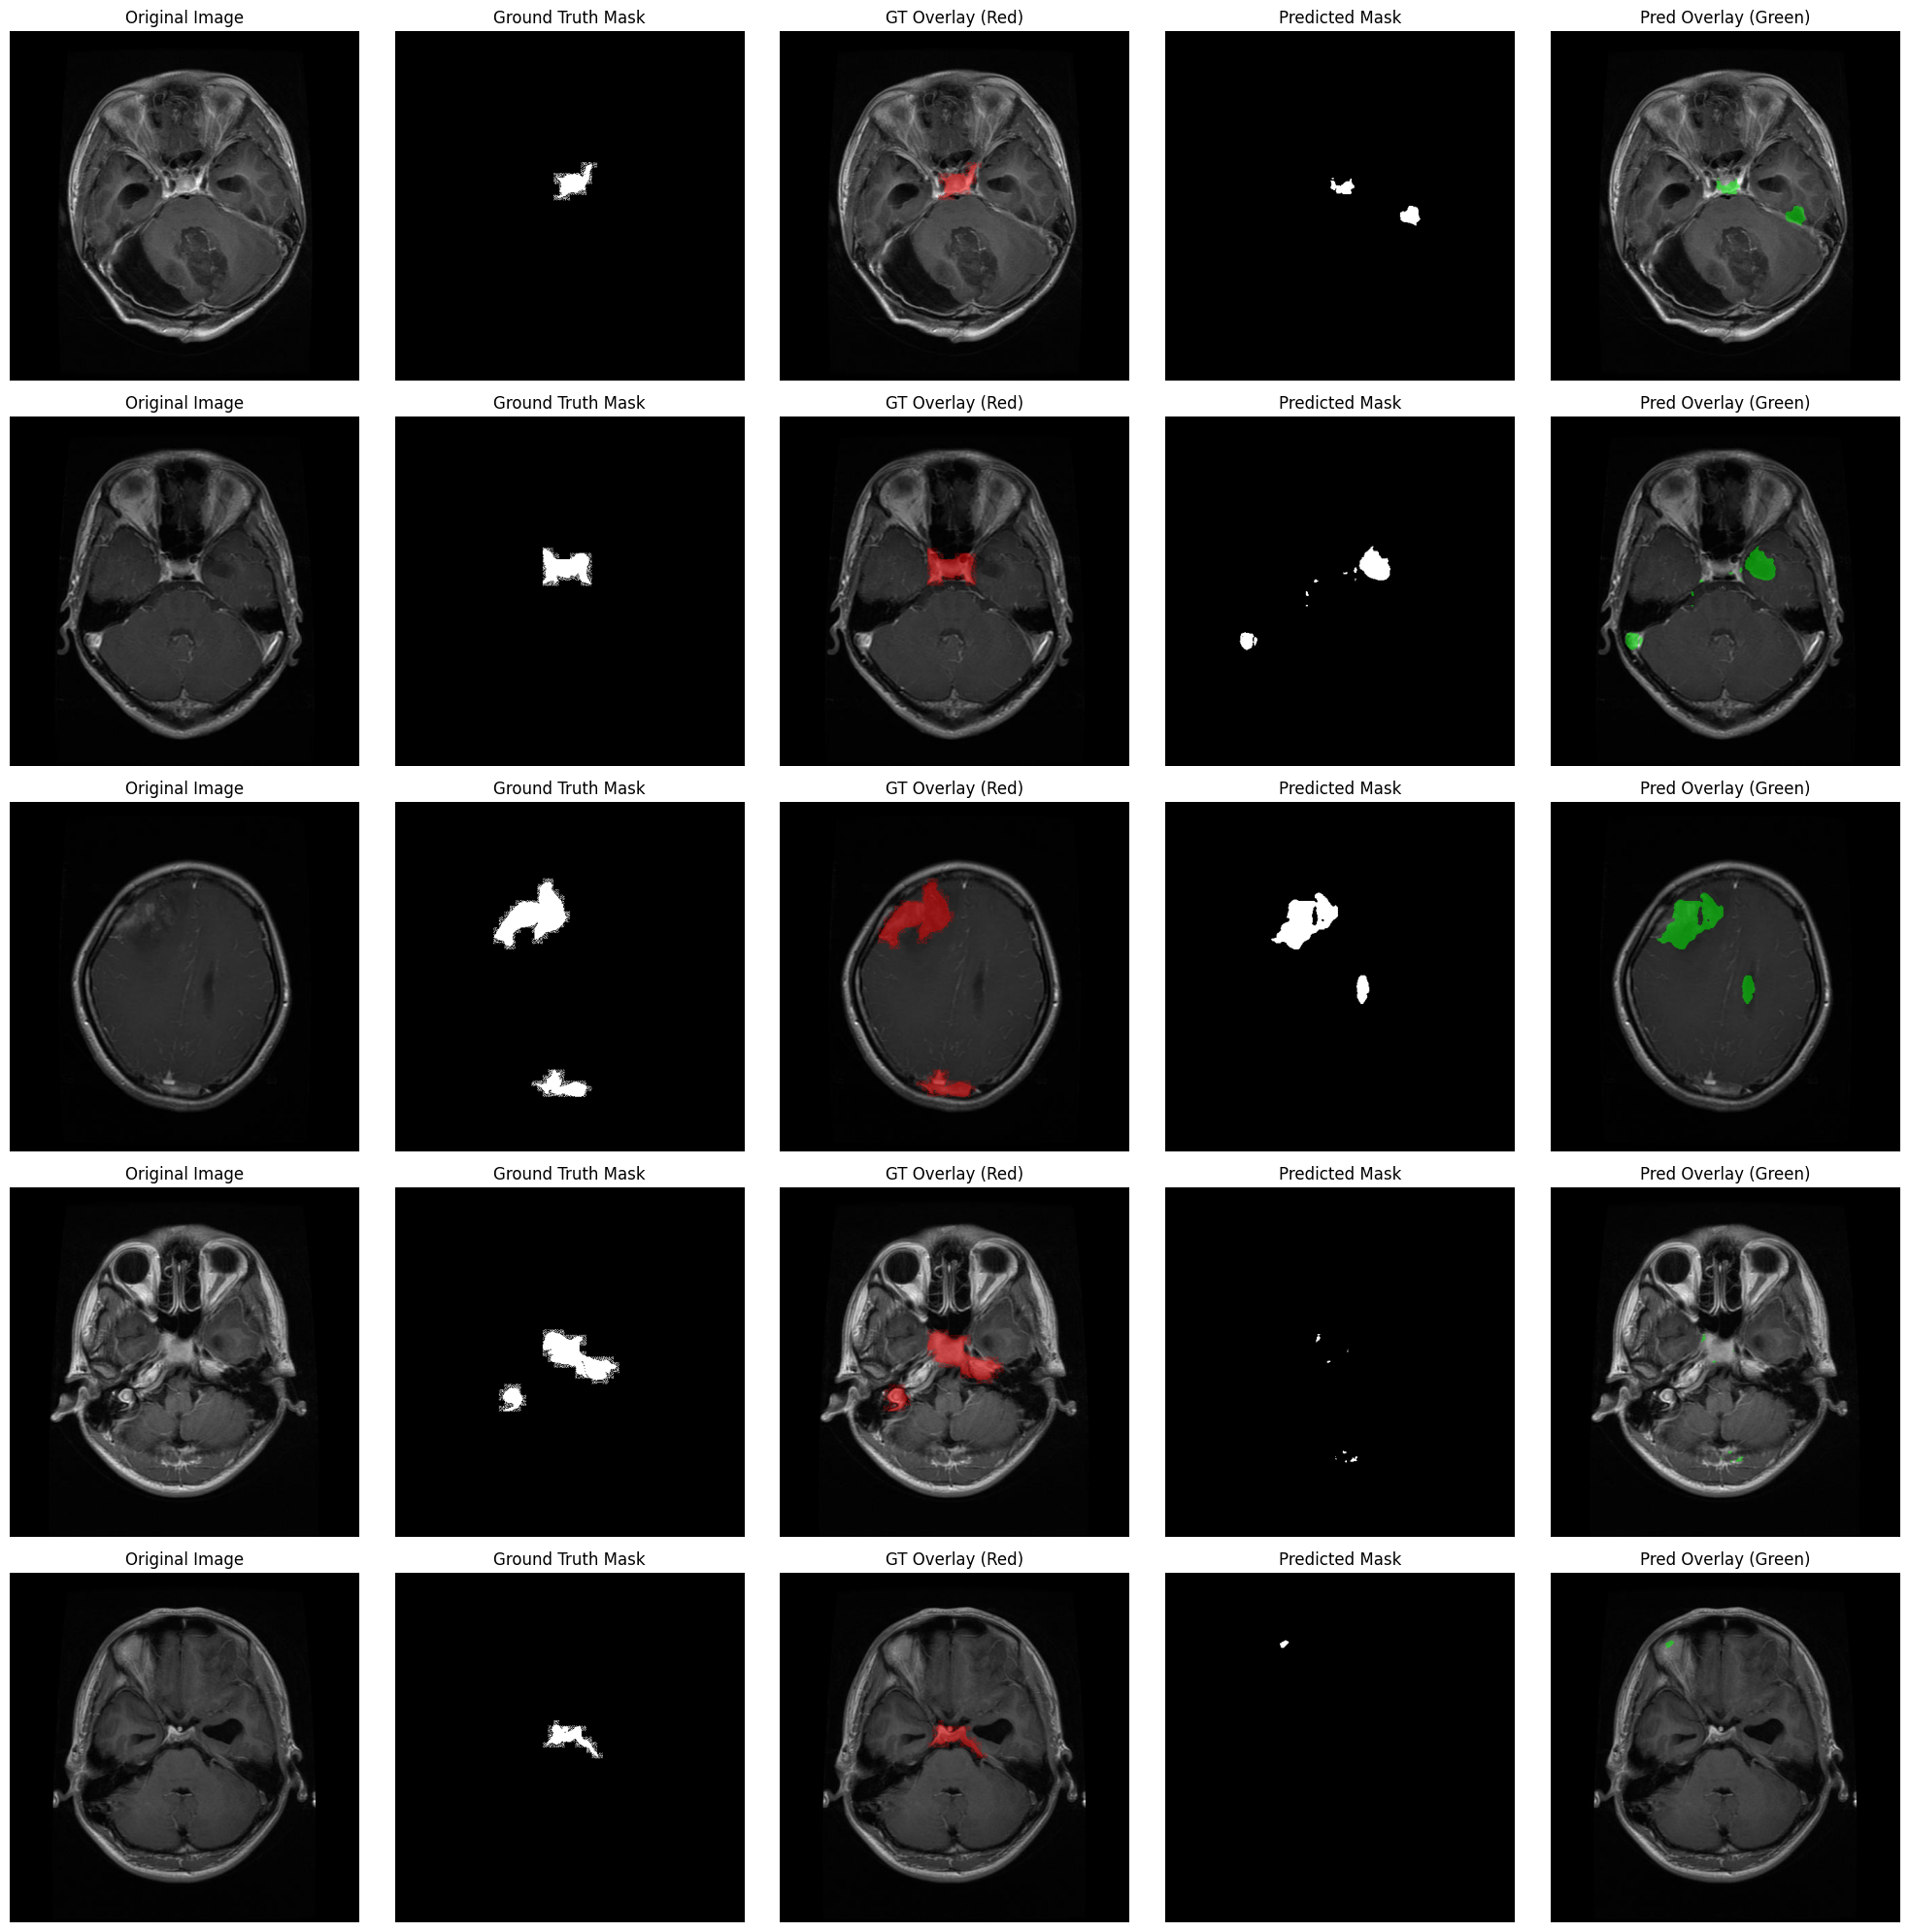

In [ ]:
# Initialize model
import matplotlib.pyplot as plt

model = UNetWithClassifier(n_channels=3, n_classes=2, clf_classes=4, bilinear=True, base_ch=64)

# Paths (update these to your actual paths)
test_csv_path = "/kaggle/input/brisc-dataset/test_index.csv"

# You can choose which model to use:
# For segmentation-only model:
# model_path = "/kaggle/input/2nd-draft-cse428-project/checkpoints/seg_only_main_best_weights.pth"

# For joint model (recommended as it's trained on both tasks):
model_path = "/kaggle/input/2nd-draft-cse428-project/checkpoints/joint_main_best_weights.pth"

# For classification-only model (won't work for segmentation):
# model_path = "/kaggle/working/checkpoints/clf_only_main_best_weights.pth"

# Run prediction and visualization
predict_and_visualize(model, test_csv_path, model_path, num_samples=5, device=device)

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        # Upsample gating signal to match spatial dimensions of x
        g1 = self.W_g(g)
        if g1.size()[2:] != x.size()[2:]:
            g1 = F.interpolate(g1, size=x.size()[2:], mode='bilinear', align_corners=True)
        
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        
        return x * psi


class AttentionUNetWithClassifier(nn.Module):
    def __init__(self, n_channels=3, n_classes=2, clf_classes=4, bilinear=True, base_ch=64):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        # Encoder (same as regular U-Net)
        self.inc = DoubleConv(n_channels, base_ch)         # 64
        self.down1 = Down(base_ch, base_ch*2)              # 128
        self.down2 = Down(base_ch*2, base_ch*4)            # 256
        self.down3 = Down(base_ch*4, base_ch*8)            # 512
        factor = 2 if bilinear else 1
        self.down4 = Down(base_ch*8, base_ch*16 // factor) # 1024->512 if bilinear
        
        # Attention gates
        self.attention1 = AttentionBlock(F_g=base_ch*16//factor, F_l=base_ch*8, F_int=base_ch*4)
        self.attention2 = AttentionBlock(F_g=base_ch*8//factor, F_l=base_ch*4, F_int=base_ch*2)
        self.attention3 = AttentionBlock(F_g=base_ch*4//factor, F_l=base_ch*2, F_int=base_ch)
        
        # Decoder with attention
        self.up1 = Up(base_ch*16, base_ch*8 // factor, bilinear=bilinear)
        self.up2 = Up(base_ch*8, base_ch*4 // factor, bilinear=bilinear)
        self.up3 = Up(base_ch*4, base_ch*2 // factor, bilinear=bilinear)
        self.up4 = Up(base_ch*2, base_ch, bilinear=bilinear)
        self.seg_out = nn.Conv2d(base_ch, n_classes, kernel_size=1)
        
        # Classifier head on bottleneck
        bottleneck_ch = base_ch*16 // factor
        self.clf_pool = nn.AdaptiveAvgPool2d(1)
        self.clf_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(bottleneck_ch, bottleneck_ch//2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(bottleneck_ch//2, clf_classes)
        )
    
    def encode(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        return x1, x2, x3, x4, x5
    
    def decode(self, x1, x2, x3, x4, x5):
        # First upsampling to get the gating signal for attention
        y = self.up1(x5, x4)  # This gives us the gating signal for next attention
        
        # Apply attention gates with proper gating signals
        x3_att = self.attention2(g=y, x=x3)
        y = self.up2(y, x3_att)
        
        x2_att = self.attention3(g=y, x=x2)
        y = self.up3(y, x2_att)
        
        y = self.up4(y, x1)
        logits = self.seg_out(y)
        return logits
    
    def classify(self, x5):
        pooled = self.clf_pool(x5)
        logits = self.clf_head(pooled)
        return logits
    
    def forward(self, x, return_both=True):
        x1, x2, x3, x4, x5 = self.encode(x)
        seg_logits = self.decode(x1, x2, x3, x4, x5) if return_both else None
        clf_logits = self.classify(x5)
        return seg_logits, clf_logits


In [ ]:
def train_one_epoch_attention(model, loader, optimizer, seg_criterion, clf_criterion, mode="joint"):
    model.train()
    total_loss = 0.0
    total_seg_loss = 0.0
    total_clf_loss = 0.0
    total = 0

    for batch in loader:
        imgs = batch["image"].to(device)
        labels = batch["label"].to(device)
        has_mask = batch["has_mask"].to(device).float()
        masks = batch["mask"].to(device)

        optimizer.zero_grad()

        if mode == "seg_only":
            seg_logits, _ = model(imgs, return_both=True)
            seg_loss = seg_criterion(seg_logits, masks)
            seg_loss = (seg_loss * has_mask.unsqueeze(1).unsqueeze(2).unsqueeze(3)).mean()
            loss = seg_loss
            clf_loss = torch.tensor(0.0, device=device)

        elif mode == "clf_only":
            _, clf_logits = model(imgs, return_both=False)
            clf_loss = clf_criterion(clf_logits, labels)
            loss = clf_loss
            seg_loss = torch.tensor(0.0, device=device)

        else:  # joint
            seg_logits, clf_logits = model(imgs, return_both=True)
            seg_loss = seg_criterion(seg_logits, masks)
            seg_loss = (seg_loss * has_mask.unsqueeze(1).unsqueeze(2).unsqueeze(3)).mean()
            clf_loss = clf_criterion(clf_logits, labels)
            loss = lambda_seg * seg_loss + lambda_clf * clf_loss

        loss.backward()
        optimizer.step()

        bs = imgs.size(0)
        total += bs
        total_loss += loss.item() * bs
        total_seg_loss += seg_loss.item() * bs
        total_clf_loss += clf_loss.item() * bs

    return {
        "loss": total_loss / total,
        "seg_loss": total_seg_loss / total,
        "clf_loss": total_clf_loss / total
    }

def run_attention_training_with_logging(model, mode="joint", epochs=15, lr=1e-3, tag=None):
    assert mode in ["seg_only", "clf_only", "joint"]
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    best_val = float('inf')
    best_state = None

    history = {
        "epoch": [],
        "train_loss": [],
        "train_seg_loss": [],
        "train_clf_loss": [],
        "val_loss": [],
        "val_seg_loss": [],
        "val_clf_loss": [],
        "val_dice": [],
        "val_acc": []
    }

    time_tag = datetime.now().strftime("%Y%m%d-%H%M%S")
    run_tag = tag or f"attn_{mode}_{time_tag}"

    for epoch in range(1, epochs+1):
        tr_metrics = train_one_epoch_attention(model, train_loader, optimizer, seg_criterion, clf_criterion, mode=mode)
        val_metrics = evaluate(model, val_loader, seg_criterion, clf_criterion, mode=mode)

        scheduler.step(val_metrics["loss"])

        # Save per-epoch checkpoint
        torch.save({
            "epoch": epoch,
            "mode": mode,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "val_loss": val_metrics["loss"],
        }, os.path.join(ckpt_dir, f"{run_tag}_epoch{epoch:02d}.pth"))

        # Track best weights
        if val_metrics["loss"] < best_val:
            best_val = val_metrics["loss"]
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            torch.save(best_state, os.path.join(ckpt_dir, f"{run_tag}_best_weights.pth"))

        # Log history
        history["epoch"].append(epoch)
        history["train_loss"].append(tr_metrics["loss"])
        history["train_seg_loss"].append(tr_metrics.get("seg_loss", 0.0))
        history["train_clf_loss"].append(tr_metrics.get("clf_loss", 0.0))
        history["val_loss"].append(val_metrics["loss"])
        history["val_seg_loss"].append(val_metrics.get("seg_loss", 0.0))
        history["val_clf_loss"].append(val_metrics.get("clf_loss", 0.0))
        history["val_dice"].append(val_metrics.get("dice", None))
        history["val_acc"].append(val_metrics.get("acc", None))

        print(f"[Attention {mode}] Epoch {epoch:02d}: "
              f"train_loss={tr_metrics['loss']:.4f} seg={tr_metrics['seg_loss']:.4f} clf={tr_metrics['clf_loss']:.4f} | "
              f"val_loss={val_metrics['loss']:.4f} seg={val_metrics['seg_loss']:.4f} clf={val_metrics['clf_loss']:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)

    # Save history JSON
    with open(os.path.join(out_dir, f"history_{run_tag}.json"), "w") as f:
        json.dump(history, f, indent=2)

    # Plot helpers (same as original)
    def _plot_series(xs, series, title, fname, ylabel="Loss"):
        plt.figure(figsize=(7,5))
        for lbl, ys in series.items():
            if ys is None: 
                continue
            plt.plot(xs, ys, label=lbl)
        plt.xlabel("Epoch")
        plt.ylabel(ylabel)
        plt.title(title)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        path = os.path.join(fig_dir, fname)
        plt.savefig(path, dpi=150)
        plt.close()
        return path

    epochs_list = history["epoch"]
    if mode == "seg_only":
        _plot_series(
            epochs_list,
            {"train_seg_loss": history["train_seg_loss"], "val_seg_loss": history["val_seg_loss"]},
            "Attention U-Net Segmentation Loss (seg_only)",
            f"{run_tag}_seg_losses.png"
        )
    elif mode == "clf_only":
        _plot_series(
            epochs_list,
            {"train_clf_loss": history["train_clf_loss"], "val_clf_loss": history["val_clf_loss"]},
            "Attention U-Net Classification Loss (clf_only)",
            f"{run_tag}_clf_losses.png"
        )
    else:  # joint
        _plot_series(
            epochs_list,
            {
                "train_seg_loss": history["train_seg_loss"],
                "val_seg_loss": history["val_seg_loss"],
                "train_clf_loss": history["train_clf_loss"],
                "val_clf_loss": history["val_clf_loss"]
            },
            "Attention U-Net Joint Training Losses (Seg + Clf)",
            f"{run_tag}_joint_losses.png"
        )
        # Optional: plot total losses too
        _plot_series(
            epochs_list,
            {"train_total": history["train_loss"], "val_total": history["val_loss"]},
            "Attention U-Net Total Loss (Joint)",
            f"{run_tag}_total_losses.png"
        )

    return best_val, history


In [ ]:
# Create Attention U-Net model
print("Training Attention U-Net...")
attn_model = AttentionUNetWithClassifier(
    n_channels=3, 
    n_classes=seg_num_classes,
    clf_classes=clf_num_classes, 
    bilinear=True, 
    base_ch=64
).to(device)

# Train with different modes
print("Training Attention U-Net segmentation-only...")
best_val_attn_seg, hist_attn_seg = run_attention_training_with_logging(
    attn_model, mode="seg_only", epochs=10, lr=1e-3, tag="attn_seg_only_main"
)


Training Attention U-Net...
Training Attention U-Net segmentation-only...
[Attention seg_only] Epoch 01: train_loss=0.0321 seg=0.0321 clf=0.0000 | val_loss=0.0139 seg=0.0139 clf=0.0000
[Attention seg_only] Epoch 02: train_loss=0.0112 seg=0.0112 clf=0.0000 | val_loss=0.0096 seg=0.0096 clf=0.0000
[Attention seg_only] Epoch 03: train_loss=0.0084 seg=0.0084 clf=0.0000 | val_loss=0.0075 seg=0.0075 clf=0.0000
[Attention seg_only] Epoch 04: train_loss=0.0070 seg=0.0070 clf=0.0000 | val_loss=0.0080 seg=0.0080 clf=0.0000
[Attention seg_only] Epoch 05: train_loss=0.0063 seg=0.0063 clf=0.0000 | val_loss=0.0074 seg=0.0074 clf=0.0000
[Attention seg_only] Epoch 06: train_loss=0.0055 seg=0.0055 clf=0.0000 | val_loss=0.0075 seg=0.0075 clf=0.0000
[Attention seg_only] Epoch 07: train_loss=0.0051 seg=0.0051 clf=0.0000 | val_loss=0.0047 seg=0.0047 clf=0.0000
[Attention seg_only] Epoch 08: train_loss=0.0050 seg=0.0050 clf=0.0000 | val_loss=0.0056 seg=0.0056 clf=0.0000
[Attention seg_only] Epoch 09: train_l

In [ ]:
print("Training Attention U-Net joint multi-task...")
best_val_attn_joint, hist_attn_joint = run_attention_training_with_logging(
    attn_model, mode="joint", epochs=15, lr=1e-3, tag="attn_joint_main"
)

Training Attention U-Net joint multi-task...
[Attention joint] Epoch 01: train_loss=0.8979 seg=0.0063 clf=0.8916 | val_loss=0.4554 seg=0.0064 clf=0.4490
[Attention joint] Epoch 02: train_loss=0.6220 seg=0.0059 clf=0.6161 | val_loss=0.4842 seg=0.0058 clf=0.4785
[Attention joint] Epoch 03: train_loss=0.5518 seg=0.0055 clf=0.5463 | val_loss=0.3846 seg=0.0054 clf=0.3792
[Attention joint] Epoch 04: train_loss=0.5162 seg=0.0056 clf=0.5107 | val_loss=0.3508 seg=0.0049 clf=0.3459
[Attention joint] Epoch 05: train_loss=0.4372 seg=0.0051 clf=0.4321 | val_loss=0.3594 seg=0.0048 clf=0.3545
[Attention joint] Epoch 06: train_loss=0.4039 seg=0.0049 clf=0.3990 | val_loss=0.5062 seg=0.0046 clf=0.5016
[Attention joint] Epoch 07: train_loss=0.3659 seg=0.0048 clf=0.3611 | val_loss=0.3095 seg=0.0046 clf=0.3049
[Attention joint] Epoch 08: train_loss=0.3256 seg=0.0045 clf=0.3211 | val_loss=0.5484 seg=0.0049 clf=0.5434
[Attention joint] Epoch 09: train_loss=0.3453 seg=0.0044 clf=0.3409 | val_loss=0.3266 seg=0

In [ ]:
attn_metrics = evaluate(attn_model, val_loader, seg_criterion, clf_criterion, mode="joint")
print(f"Attention U-Net - Dice: {attn_metrics.get('dice', 0):.4f}, Accuracy: {attn_metrics.get('acc', 0):.4f}")

Attention U-Net - Dice: 0.8100, Accuracy: 0.9450
